In [1]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
class TicTacToe:
    def __init__(self):
        self.reset()

    def reset(self):
        self.board = np.zeros(9, dtype=int)
        self.current_player = 1  # X = +1, O = -1
        return self.board.copy()

    def legal_actions(self):
        return [i for i in range(9) if self.board[i] == 0]

    def play(self, action):
        self.board[action] = self.current_player
        self.current_player *= -1

    def winner(self):
        win_states = [
            (0,1,2),(3,4,5),(6,7,8),
            (0,3,6),(1,4,7),(2,5,8),
            (0,4,8),(2,4,6)
        ]
        for a,b,c in win_states:
            s = self.board[a] + self.board[b] + self.board[c]
            if s == 3: return 1
            if s == -3: return -1
        return 0

    def is_terminal(self):
        return self.winner() != 0 or len(self.legal_actions()) == 0

    def outcome(self, symbol):
        w = self.winner()
        if w == symbol:
            return 1.0
        elif w == 0:
            return 0.5
        else:
            return 0.0

In [3]:
class TDAgent:
    def __init__(self, symbol, epsilon=0.1, alpha=0.1):
        self.symbol = symbol
        self.epsilon = epsilon
        self.alpha = alpha
        self.V = defaultdict(lambda: 0.5)
        self.states = []

    def reencode_player(self, board):
        return tuple(board * self.symbol)

    def choose_action(self, env, strategy):
        actions = env.legal_actions()

        # ε-Greedy
        if strategy == "epsilon-greedy":
            if random.random() < self.epsilon:
                return random.choice(actions)

        # Greedy selection
        best_value = -1
        best_action = None

        for a in actions:
            env.board[a] = self.symbol
            state = self.reencode_player(env.board)
            value = self.V[state]
            env.board[a] = 0

            if value > best_value:
                best_value = value
                best_action = a

        return best_action

    def td_update(self, reward):
        self.V[self.states[-1]] = reward

        for i in reversed(range(len(self.states) - 1)):
            s_t = self.states[i]
            s_t1 = self.states[i + 1]
            self.V[s_t] += self.alpha * (self.V[s_t1] - self.V[s_t])

In [4]:
def train_td(strategy_X, strategy_O, num_episodes=3000):
    env = TicTacToe()

    agent_X = TDAgent(symbol=1)
    agent_O = TDAgent(symbol=-1)

    win_trace_X = []
    win_trace_O = []
    final_trajectory = None

    # -------------------------------
    # TRAINING LOOP (>1000 episodes)
    # -------------------------------
    for episode in range(num_episodes):

        env.reset()
        agent_X.states = []
        agent_O.states = []

        # Game loop
        while not env.is_terminal():

            if env.current_player == 1:
                action = agent_X.choose_action(env, strategy_X)
                env.play(action)
                state = agent_X.reencode_player(env.board)
                agent_X.states.append(state)

            else:
                action = agent_O.choose_action(env, strategy_O)
                env.play(action)
                state = agent_O.reencode_player(env.board)
                agent_O.states.append(state)

        # Terminal reached → update values
        reward_X = env.outcome(1)
        reward_O = env.outcome(-1)

        agent_X.td_update(reward_X)
        agent_O.td_update(reward_O)

        win_trace_X.append(reward_X)
        win_trace_O.append(reward_O)

        if episode == num_episodes - 1:
            final_trajectory = env.board.reshape(3,3)

    curve_X = np.cumsum(win_trace_X) / np.arange(1, num_episodes + 1)
    curve_O = np.cumsum(win_trace_O) / np.arange(1, num_episodes + 1)
    return final_trajectory, curve_X, curve_O

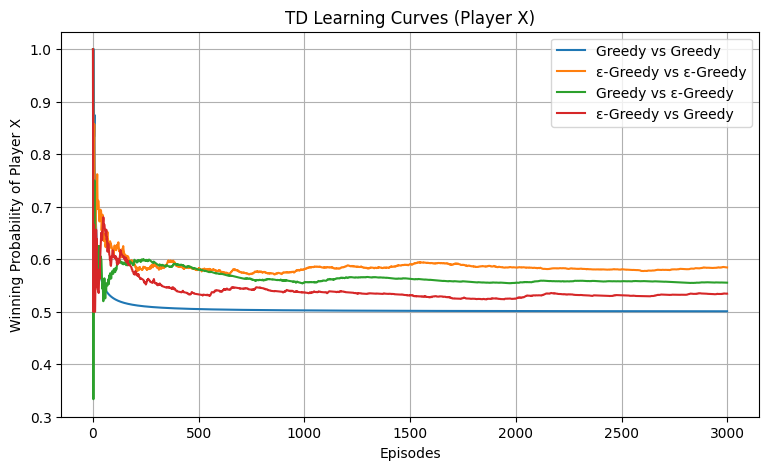

In [5]:
configs = [
    ("greedy", "greedy", "Greedy vs Greedy"),
    ("epsilon-greedy", "epsilon-greedy", "ε-Greedy vs ε-Greedy"),
    ("greedy", "epsilon-greedy", "Greedy vs ε-Greedy"),
    ("epsilon-greedy", "greedy", "ε-Greedy vs Greedy")
]

plt.figure(figsize=(9, 5))

for sx, so, label in configs:
    traj, curve_X, curve_O = train_td(sx, so)
    plt.plot(curve_X, label=label)

plt.xlabel("Episodes")
plt.ylabel("Winning Probability of Player X")
plt.title("TD Learning Curves (Player X)")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
print("Final Trajectory (Config 4):")
print(traj)

Final Trajectory (Config 4):
[[-1  1  1]
 [ 1  1 -1]
 [-1  1 -1]]


In [7]:
def td_update(self, reward):
    # If no states were visited, nothing to update
    if not self.states:
        return

    # Terminal target = reward
    target = reward

    # Update from last visited state backward
    for i in reversed(range(len(self.states))):
        s_t = self.states[i]
        self.V[s_t] += self.alpha * (target - self.V[s_t])
        target = self.V[s_t]  # bootstrapping backward

In [8]:
def train_td(strategy_X, strategy_O, num_episodes=3000):
    env = TicTacToe()

    agent_X = TDAgent(symbol=1)
    agent_O = TDAgent(symbol=-1)

    win_trace_X = []
    win_trace_O = []
    final_trajectory = None

    for episode in range(num_episodes):

        env.reset()
        agent_X.states = []
        agent_O.states = []

        # Initialize trajectory ONLY for last episode
        if episode == num_episodes - 1:
            final_trajectory = []

        # Game loop
        while not env.is_terminal():

            if env.current_player == 1:
                action = agent_X.choose_action(env, strategy_X)
                env.play(action)

                if episode == num_episodes - 1:
                    final_trajectory.append(env.board.copy())

                state = agent_X.reencode_player(env.board)
                agent_X.states.append(state)

            else:
                action = agent_O.choose_action(env, strategy_O)
                env.play(action)

                if episode == num_episodes - 1:
                    final_trajectory.append(env.board.copy())

                state = agent_O.reencode_player(env.board)
                agent_O.states.append(state)

        # Terminal update
        reward_X = env.outcome(1)
        reward_O = env.outcome(-1)

        agent_X.td_update(reward_X)
        agent_O.td_update(reward_O)

        win_trace_X.append(reward_X)
        win_trace_O.append(reward_O)

    curve_X = np.cumsum(win_trace_X) / np.arange(1, num_episodes + 1)
    curve_O = np.cumsum(win_trace_O) / np.arange(1, num_episodes + 1)

    return final_trajectory, curve_X, curve_O

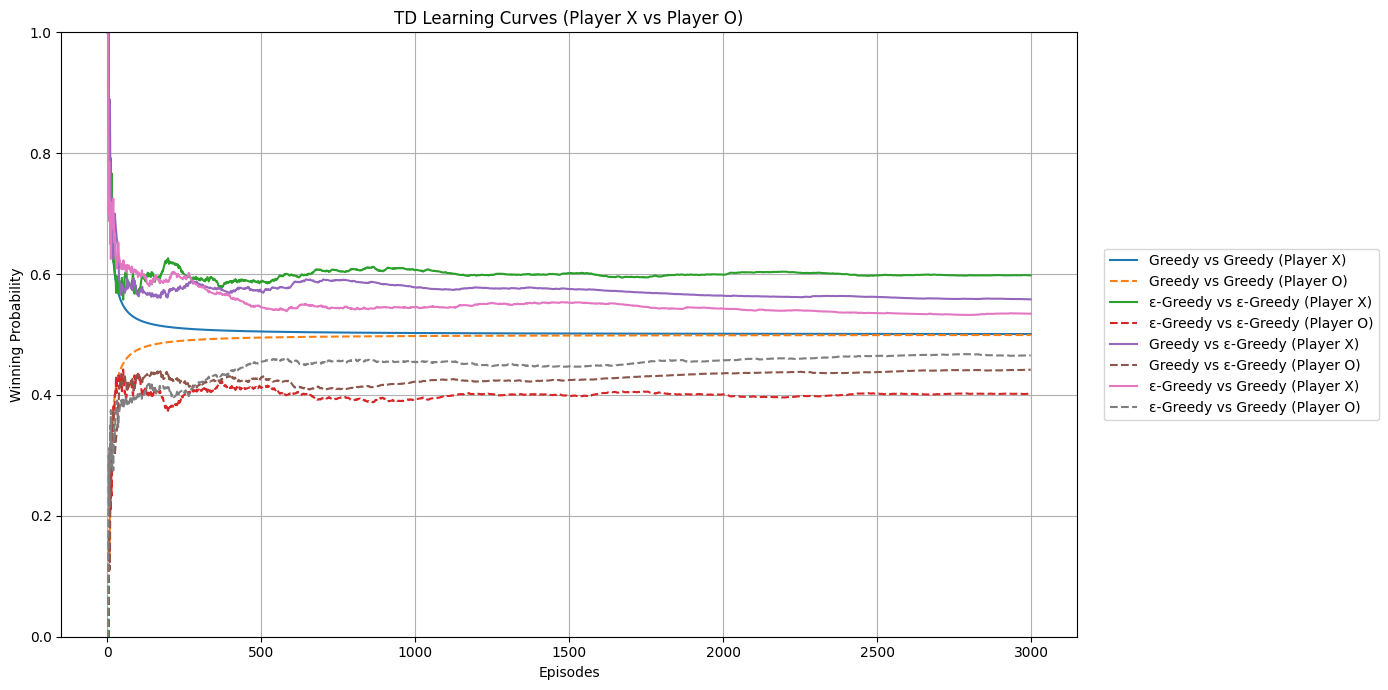

In [9]:
configs = [
    ("greedy", "greedy", "Greedy vs Greedy"),
    ("epsilon-greedy", "epsilon-greedy", "ε-Greedy vs ε-Greedy"),
    ("greedy", "epsilon-greedy", "Greedy vs ε-Greedy"),
    ("epsilon-greedy", "greedy", "ε-Greedy vs Greedy")
]

plt.figure(figsize=(14, 7))

for sx, so, label in configs:
    traj, curve_X, curve_O = train_td(sx, so)

    plt.plot(curve_X, label=f"{label} (Player X)")         
    plt.plot(curve_O, "--", label=f"{label} (Player O)")   

plt.ylim(0.0, 1.0)
plt.xlabel("Episodes")
plt.ylabel("Winning Probability")
plt.title("TD Learning Curves (Player X vs Player O)")
plt.grid(True)

# Move legend outside (right side)
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5))

# Adjust layout so legend fits properly
plt.tight_layout()

plt.show()